In [1]:
import numpy as np
import scipy.stats as s
import empiricaldist as ed
import matplotlib.pyplot as plt
from collections import Counter
import utils as u
import pandas as pd

### Light bulbs

#### Using complete update

In [5]:
df = pd.read_csv('lamps.csv')
df.set_index('i', drop=True)
df.head()

,i,h,f,K
0,0,0,0,50
1,1,840,2,48
2,2,852,1,47
3,3,936,1,46
4,4,960,1,45


In [6]:
df.describe()

,i,h,f,K
count,33.00000,33.000000,33.000000,33.000000
mean,16.00000,1363.636364,1.515152,25.636364
std,9.66954,452.441558,1.093195,15.968364
min,0.00000,0.000000,0.000000,0.000000
25%,8.00000,1032.000000,1.000000,13.000000
50%,16.00000,1356.000000,1.000000,27.000000
75%,24.00000,1644.000000,2.000000,40.000000
max,32.00000,2568.000000,5.000000,50.000000


Column h contains the times when bulbs failed in hours; Column f contains the number of bulbs that failed at each time. We can represent these values and frequencies using a Pmf

In [8]:
pmf_bulb = ed.Pmf(df['f'].values, df['h'].values)
pmf_bulb.normalize()
pmf_bulb.head(10)

,probs
0,0.00
840,0.04
852,0.02
936,0.02
960,0.02
972,0.02
996,0.02
1008,0.02
1032,0.04
1104,0.02


Assuming that these data are well modeled by a Weibull distribution, let’s estimate the parameters that fit the data. Again, I’ll start with uniform priors for lamda and k.

In [9]:
lams = np.linspace(1000, 2000, num=51)
prior_lam = u.make_uniform(lams, name='lambda')

ks = np.linspace(1, 10, num=51)
prior_k = u.make_uniform(ks, name='k')

prior_bulb = u.make_joint(prior_lam, prior_k)

Although we have data for 50 light bulbs, there are only 32 unique lifetimes in the dataset. For the update, it is convenient to express the data in the form of 50 lifetimes, with each lifetime repeated the given number of times. We can use np.repeat to transform the data.

In [10]:
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

In [11]:
def weibull_dist(lam, k):
    return s.weibull_min(k, scale=lam)

def update_weibull(prior, data):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    u.normalize(posterior)

    return posterior

def update_weibull_incomplete(prior, data):
    """Update the prior using incomplete data.
    Foe example knowing only lower bound: https://allendowney.github.io/ThinkBayes2/chap14.html#incomplete-data
    """
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    # evaluate the survival function
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)

    posterior = prior * likelihood
    u.normalize(posterior)

    return posterior

In [12]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

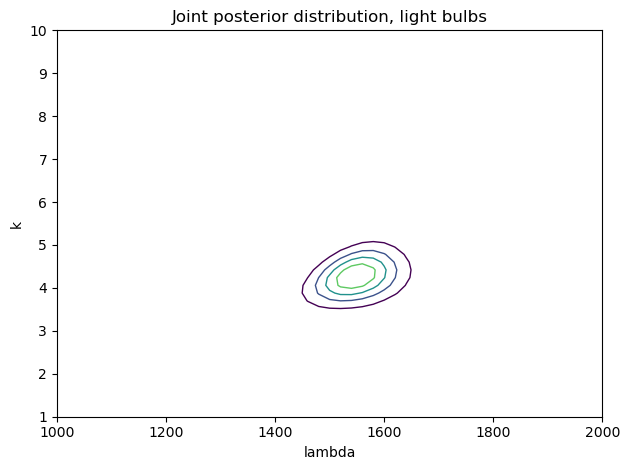

In [13]:
u.plot_contour(posterior_bulb)
u.decorate(title='Joint posterior distribution, light bulbs')

In [14]:
def joint_weibull_mean(joint):
    """Compute the mean of a joint distribution of Weibulls."""
    lam_mesh, k_mesh = np.meshgrid(
        joint.columns, joint.index
    )
    means = weibull_dist(lam_mesh, k_mesh).mean()
    prod = means * joint # weight joint means by posterior
    return prod.to_numpy().sum() # sum of weighted means

In [15]:
joint_weibull_mean(posterior_bulb)

1412.7242774305005

#### Incomplete information

The previous update was not quite right, because it assumed each light bulb died at the instant we observed it.
According to the report, the researchers only checked the bulbs every 12 hours. So if they see that a bulb has died, they know only that it died during the 12 hours since the last check.

It is more strictly correct to use the following update function, which uses the CDF of the Weibull distribution to compute the probability that a bulb dies during a given 12 hour interval.

In [16]:
def update_weibull_between(prior, data, dt=12):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data
    )
    dist = weibull_dist(lam_mesh, k_mesh)
    cdf1 = dist.cdf(data_mesh)
    cdf2 = dist.cdf(data_mesh-12)
    likelihood = (cdf1 - cdf2).prod(axis=2)

    posterior = prior * likelihood
    u.normalize(posterior)

    return posterior

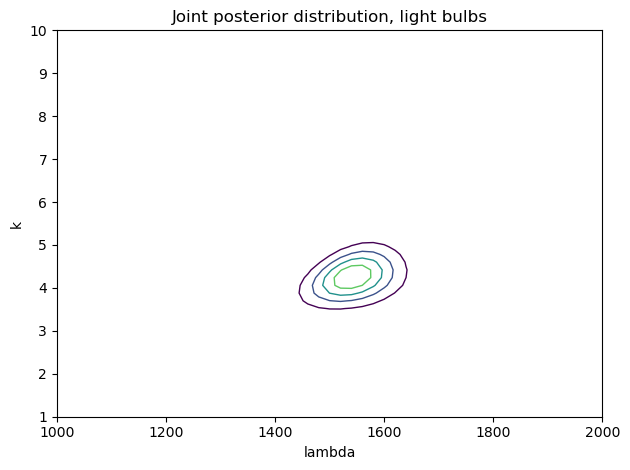

In [17]:
posterior_bulb2 = update_weibull_between(prior_bulb, data_bulb)

u.plot_contour(posterior_bulb2)
u.decorate(title='Joint posterior distribution, light bulbs')

In [18]:
joint_weibull_mean(posterior_bulb2)

1406.8171982320873

When we take into account the 12-hour interval between observations, the posterior mean is about 6 hours less. And that makes sense: if we assume that a bulb is equally likely to expire at any point in the interval, the average would be the midpoint of the interval.

#### Posterior predictive distribution

Suppose you install 100 light bulbs of the kind in the previous section, and you come back to check on them after 1000 hours. Based on the posterior distribution we just computed, what is the distribution of the number of bulbs you find dead?

If we knew the parameters of the Weibull distribution for sure, the answer would be a binomial distribution.

**Example with known parameters**

If lamba=1550, k=4.25, then:

In [22]:
lam = 1550
k = 4.25
t = 1000

prob_dead = weibull_dist(lam, k).cdf(t)
prob_dead

0.14381685899960547

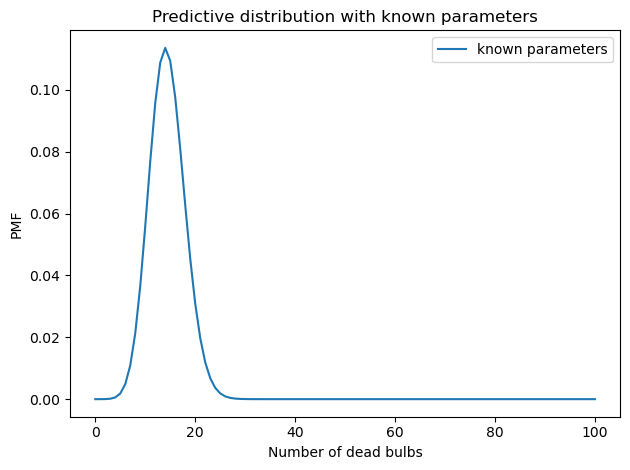

In [21]:
n = 100
p = prob_dead
dist_num_dead = u.make_binomial(n, p)

dist_num_dead.plot(label='known parameters')

u.decorate(xlabel='Number of dead bulbs',
         ylabel='PMF',
         title='Predictive distribution with known parameters')

**Real edxample**

So the posterior predictive distribution is not a single binomial; instead it is a mixture of binomials, weighted with the posterior probabilities.

We can use make_mixture to compute the posterior predictive distribution.
It doesn’t work with joint distributions, but we can convert the DataFrame that represents a joint distribution to a Series, like this:

In [23]:
posterior_series = posterior_bulb2.stack()
posterior_series.head(10)

k    lambda
1.0  1000.0    1.080654e-24
     1020.0    1.596253e-24
     1040.0    2.279356e-24
     1060.0    3.153589e-24
     1080.0    4.236317e-24
     1100.0    5.536035e-24
     1120.0    7.050311e-24
     1140.0    8.764558e-24
     1160.0    1.065182e-23
     1180.0    1.267363e-23
dtype: float64

In [24]:
pmf_seq = []
for (k, lam) in posterior_series.index:
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = u.make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

post_pred = u.make_mixture(posterior_series, pmf_seq)

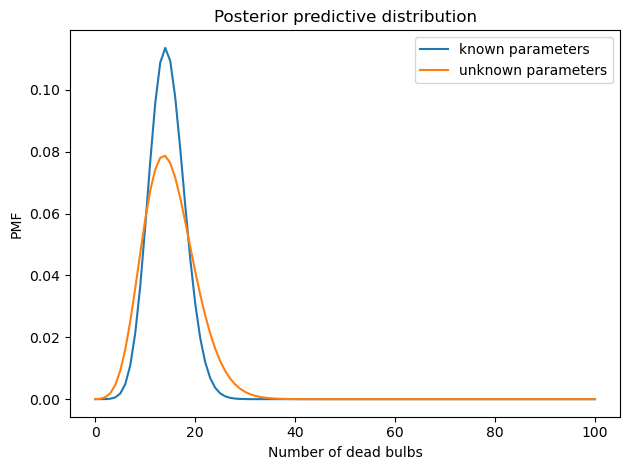

In [25]:
dist_num_dead.plot(label='known parameters')
post_pred.plot(label='unknown parameters')
u.decorate(xlabel='Number of dead bulbs',
         ylabel='PMF',
         title='Posterior predictive distribution')

### Exercises

Using data about the lifetimes of light bulbs, we computed the posterior distribution from the parameters of a Weibull distribution, lamda and k, and the posterior predictive distribution for the number of dead bulbs, out of 100, after 1000 hours.

Now suppose you do the experiment: You install 100 light bulbs, come back after 1000 hours, and find 20 dead light bulbs. Update the posterior distribution based on this data. How much does it change the posterior mean?

In [29]:
def update_weibull_upper_bound(prior, data):
    """Update the prior based on data with upper bound t.
    n: number for blbs
    t: time
    dead: how many you find dead after t
    """
    n, t, dead = data
    lam_mesh, k_mesh = np.meshgrid(
        prior.columns, prior.index
    )
    dist = weibull_dist(lam_mesh, k_mesh)
    cdf = dist.cdf(t)
    likelihood = s.binom(n, cdf).pmf(dead)

    posterior = prior * likelihood
    u.normalize(posterior)

    return posterior

In [30]:
posterior_bulb3 = update_weibull_upper_bound(posterior_bulb2, (100, 1000, 20))

1374.678766685615

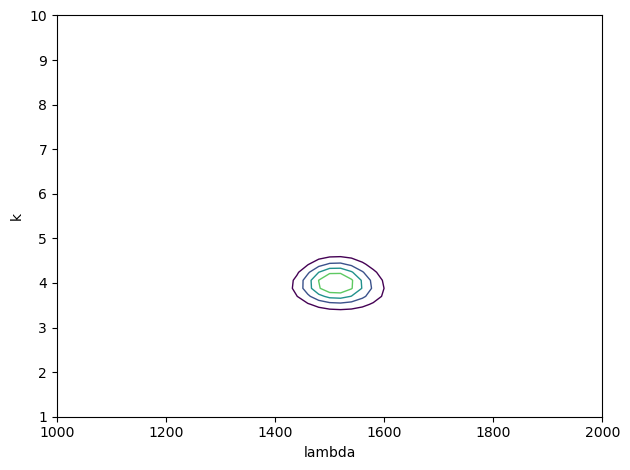

In [31]:
u.plot_contour(posterior_bulb3)
joint_weibull_mean(posterior_bulb3)

 In this exercise, we’ll use one month of data to estimate the parameters of a distribution that describes daily rainfall in Seattle. Then we’ll compute the posterior predictive distribution for daily rainfall and use it to estimate the probability of a rare event, like more than 1.5 inches of rain in a day.

According to hydrologists, the distribution of total daily rainfall (for days with rain) is well modeled by a two-parameter gamma distribution.

When we worked with the one-parameter gamma distribution in <<_TheGammaDistribution>>, we used the Greek letter

for the parameter.

For the two-parameter gamma distribution, we will use
for the “shape parameter”, which determines the shape of the distribution, and the Greek letter or theta for the “scale parameter”.

In [32]:
def gamma_dist(k, theta):
    """Makes a gamma object.
    
    k: shape parameter
    theta: scale parameter
    
    returns: gamma object
    """
    return s.gamma(k, scale=theta)

In [35]:
df = pd.read_csv('rain_data.csv')
df.head()

,STATION,NAME,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT03,WT08
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-01,4.47,0.00,66,43,NaN,NaN,NaN
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.40,0.24,58,47,1.0,NaN,NaN
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57,44,1.0,NaN,NaN
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-04,4.47,0.00,65,39,NaN,NaN,NaN
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-05,7.83,0.00,71,49,NaN,NaN,NaN


In [37]:
rained = df['PRCP']>0
df[rained].head()

,STATION,NAME,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT03,WT08
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.40,0.24,58,47,1.0,NaN,NaN
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57,44,1.0,NaN,NaN
5,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-06,12.08,0.11,62,48,NaN,NaN,NaN
10,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-11,8.95,0.01,74,54,NaN,NaN,NaN
11,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-12,6.49,0.05,65,50,1.0,NaN,NaN


<AxesSubplot:>

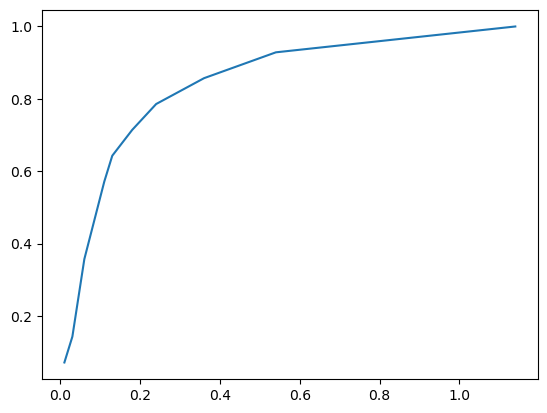

In [39]:
cdf = ed.Cdf.from_seq(df[rained]["PRCP"])
cdf.plot()

The maximum is 1.14 inches of rain is one day. To estimate the probability of more than 1.5 inches, we need to extrapolate from the data we have, so our estimate will depend on whether the gamma distribution is really a good model.

In [118]:
# Solution

# I'll use the MLE parameters of the gamma distribution
# to help me choose priors

k_est, _, theta_est = s.gamma.fit(df[rained]['PRCP'], floc=0)
k_est, theta_est

(0.8898876017525283, 0.25043291132301665)

In [129]:
thetas = np.linspace(1e-2, 1, 101)
ks = np.linspace(1e-2, 3, 101)

prior = u.make_joint(
    u.make_uniform(ks, name='k'),
    u.make_uniform(thetas, name='theta')
)

In [130]:
k_mesh, theta_mesh, data_mesh = np.meshgrid(
    ks, thetas, df[rained]['PRCP'].values
)

In [131]:
densities = gamma_dist(k_mesh, theta_mesh).pdf(data_mesh)
probs = densities.prod(axis=2)
probs.shape

(101, 101)

In [132]:
posterior = prior * probs
u.normalize(posterior)

57.81139342631766

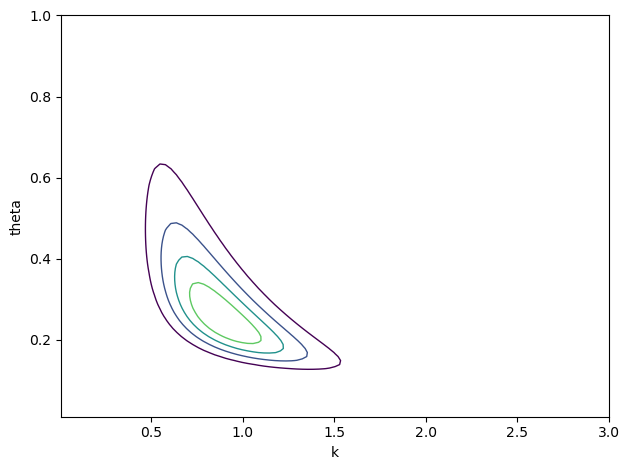

In [133]:
u.plot_contour(posterior)

In [134]:

posterior_k = u.marginal(posterior, 0)
posterior_theta = u.marginal(posterior, 1)



<AxesSubplot:xlabel='k'>

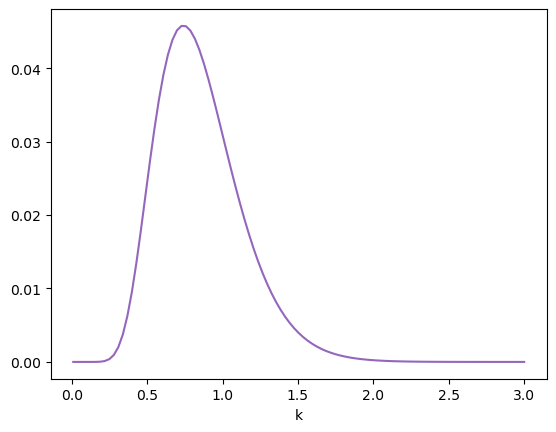

In [135]:
posterior_k.plot(color='C4')

<AxesSubplot:xlabel='theta'>

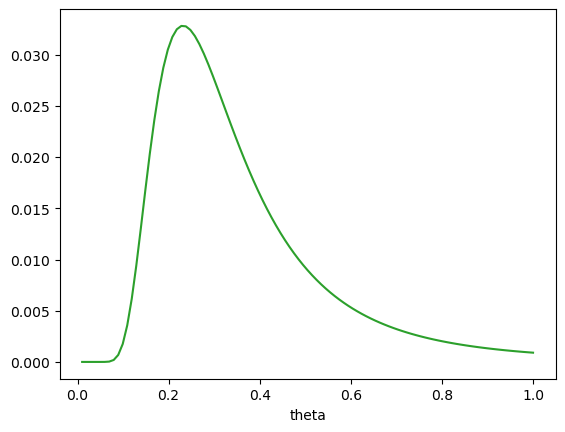

In [136]:
posterior_theta.plot(color='C2')

In [137]:
stack = posterior.stack()
stack.head()

theta  k     
0.01   0.0100    1.097409e-156
       0.0399    9.915098e-148
       0.0698    8.521406e-144
       0.0997    4.207424e-141
       0.1296    5.453897e-139
dtype: float64

In [138]:
# I'll extend the predictive distribution up to 2 inches
low, high = 0.01, 2

# Now we can iterate through `posterior_series`
# and make a sequence of predictive Pmfs, one
# for each possible pair of parameters
qs = np.linspace(low, high, num=101)
seqs = []
for (theta, k) in stack.index:
    dist = gamma_dist(k, theta)
    pmf = u.pmf_from_dist(dist, qs)
    seqs.append(pmf)

mix = u.make_mixture(stack, seqs)
    

In [143]:
mix

,probs
0.0100,0.106914
0.0299,0.078560
0.0498,0.066926
0.0697,0.059125
0.0896,0.053051
...,...
1.9204,0.000203
1.9403,0.000194
1.9602,0.000186
1.9801,0.000179


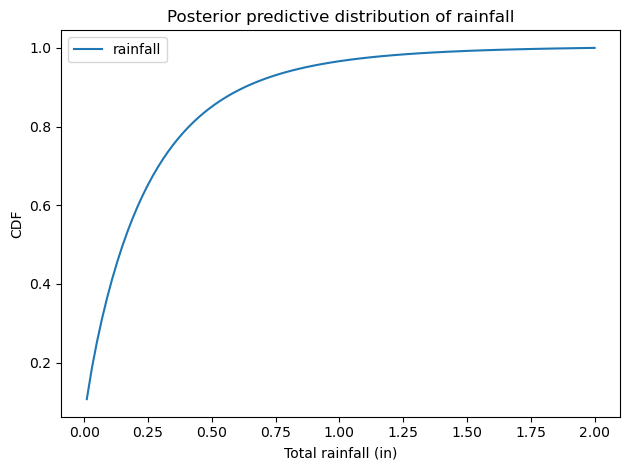

In [144]:
mix.make_cdf().plot(label='rainfall')
u.decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Posterior predictive distribution of rainfall')

In [145]:
cdf = mix.make_cdf()
p_gt = 1 - cdf(1.5)
p_gt

0.008111605615423012

In [146]:
# So it's easier to interpret as the number of rainy
# days between events, on average

1 / p_gt

123.2801552997903